In [3]:
from scipy.sparse.linalg import eigs
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import mode

# Engineering Pattern Recognition:

## _A Practical Summary - Part 1: Classification & Clustering_

### Data-driven engineering

- Engineering is progressively linked with _data science_
- Increasingly, data should incoperated in engineering practice

- *This does not imply the end of classic engineering!* Instead the inclusion of algorithms and data within scientific principals for engineering applications:

    - Design
    - Optimisation
    - Monitoring
    - Simulation/modelling

### What is machine learning?

_Machine learning is a set of methods that can learn and detect patterns in data,
and then use these uncovered patterns to predict future data, or perform other
kinds of decision making_ (K.P. Murphy 2012)

**Pattern recognition**, a motivating example:

<img src='https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/222/2014/12/20101958/Figure_03_04_01.jpg' width='500'/>

(_courses.lumenlearning.com_)

### Types of Machine Learning

- Supervised: input $\mathbf{x}_i$ and output $\mathbf{y}_i$ data available to _train_ algorithms
$$
\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1}^N
$$
Goal is to provide a _mapping_ from the inputs to the outputs

<img src="https://www.hackneycitizen.co.uk/wp-content/uploads/Paul.Smith-credit-stephen-mcgrath-009.jpg" width="500"/>

(_Hackney Citizen, 2013_)

- Unsupervised: Find interesting patterns in input data only - less well defined

$$
\mathcal{D} = \{\mathbf{x}_i\}_{i=1}^N
$$

<img src="images/ML_types.png" width="500"/>

(_LITSLINK, An Introduction to Machine Learning Algorithms, 2019_)

<img src="images/cat_eg.png" width="250"/><img src="images/regression_eg.png" width="250"/>

(_P. Gardner, 2019_)

### Typical work-flow in Engineering applications

- Data acquisition
- Preprocessing
- **Feature Extraction**
- Machine learning (feature discrimination):
    - **Classification** (supervised)
    - **Clustering** (unsupervised)
    - **Regression** (supervised)
    
(_SHM framework: Farrar, Worden, 2013_)

### Case Study: AE Classification


Acoustic Emissions (AE) dataset - Non Destructive Testing applications


Test concerning the box-girder of of a bridge structure (Rhys Pullin et al. Cardiff University).

<img src="images/box_girder.jpg" width="200"/>

(_Engineering Discoveries, Facebook, 2018_)

Experiments:
- 0.1 to 85.00 kN cyclic loading
- 91 AE burst **observations** ($N = 91$)
- each bust has 2048 samples 

AE array dimensions:(91, 2048)


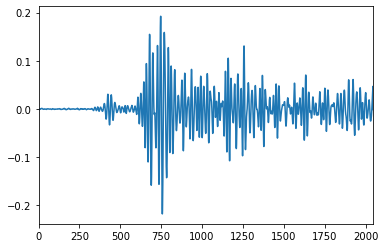

In [4]:
# load the (processed) AE burst signals
AE = np.loadtxt('data/full_burst_data.txt')
# print the shape of the array
print('AE array dimensions:' + str(AE.shape))

# pick one burst signal at random
i = np.random.randint(0, AE.shape[0])
# plot the signal
plt.plot(AE[i,:])
plt.xlim([0, AE.shape[1]])
plt.show()

## Feature Extraction

### Feature Extraction

- Categorise different AE sources, particularly crack growth
- Can machine learning find patterns in these data?

Feature extraction: identification of _features_ from the measured signals that are informative, given the application

i.e. features that are sensitive to changes in the AE signals, relating to crack growth

Typical AE features:
- duration
- peak amplitude
- rise-time
- ring-down count

<img src="images/trad_ae_f2.png" width="450"/>

We now have 91 **observations** (bursts) represented by 4 features each

$$
\mathbf{x}_i \in \mathbb{R}^4
$$

### Feature Extraction: Dimensionality Reduction (Visualisation)

It would be useful (for the presentation) if we could plot the data, two-dimensions are useful for this.
$$
\mathbb{R}^4 \rightarrow \mathbb{R}^2
$$

Define a new representation of $\mathbf{x}_i$, which is a weighted sum of the original 4 features
$$
\hat{\mathbf{x}}_i = \mathbf{W}^\top \mathbf{x}_i
$$

The weights are defined, such that the scatter (variance) is maximised (Principal Component Analysis)
$$
\hat{\mathbf{x}}_i \in \mathbb{R}^2
$$

dimensions of orginal array:(91, 4)
dimensions of new array:(91, 2)


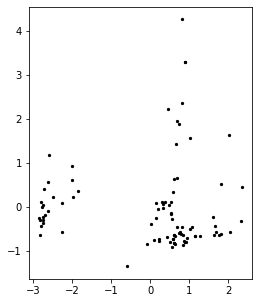

In [5]:
# load the 4 dimensional data
X = np.loadtxt('data/F_AE.txt')
print('dimensions of orginal array:' + str(X.shape))

# find the weights
_, W = eigs(np.cov(X.T), 2)

# redefine X
X = X @ W.real
print('dimensions of new array:' + str(X.shape))

# plot the data
plt.figure(figsize=[4, 5])
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.show()

## Classification
### Supervised learning

### Classification: supervised learning

Label each of the AE signals:
- crack extension, $\mathbf{y}_i=1$
- frictional processes away from the crack, $\mathbf{y}_i=2$
- crack related events, $\mathbf{y}_i=3$

A total of 91 labels, for each of the 91 observations

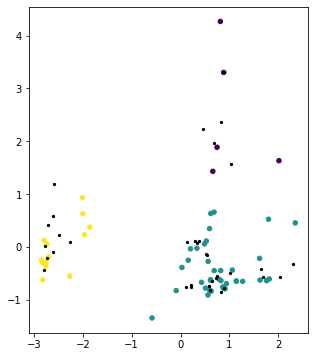

In [6]:
# define training and test indices
train = np.random.choice(91, 55, replace=False)
test = np.setdiff1d(range(91), train)

# load labels for the data
Y = np.loadtxt('data/Y.txt')

# plot the data, colour with labels
plt.figure(figsize=[5, 6])
plt.scatter(X[train,0], X[train,1], s=20, c=Y[train])
plt.scatter(X[test,0], X[test,1], s=5, c='k')
plt.show()

### Classification: K-Nearest Neighbours

For a new observation $\mathbf{x}_*$ classify according to the majority label for the K-Nearest-Neighbours

Find the distance between $\mathbf{x}_*$ and all the data in the training-set:
$$
d(\mathbf{x}_*, \mathbf{x}_i) = (\mathbf{x}_* - \mathbf{x}_i)^\top (\mathbf{x}_* - \mathbf{x}_i) \qquad \forall i \in \textrm{train}
$$

Classify according to the majority label for K-NN


In [7]:
def mesh():
    h = 0.1
    x1, x2 = np.meshgrid(np.arange(X.min(0)[0]-1, X.max(0)[0]+1, h),
                         np.arange(X.min(0)[1]-1, X.max(0)[1]+1, h))
    xx = np.c_[x1.ravel(), x2.ravel()]
    d = cdist(xx, X[train, :]) # pair-wise distances
    ik = d.argsort()[:, :K] # the indices for the K closest points
    yy = []
    for i in range(xx.shape[0]):
        pred,_ = mode(Y[train][ik[i,:]]) # mode label in the set of K nearest points
        yy.append(pred)
    yy = np.array(yy).reshape(x1.shape)
    return x1, x2, yy

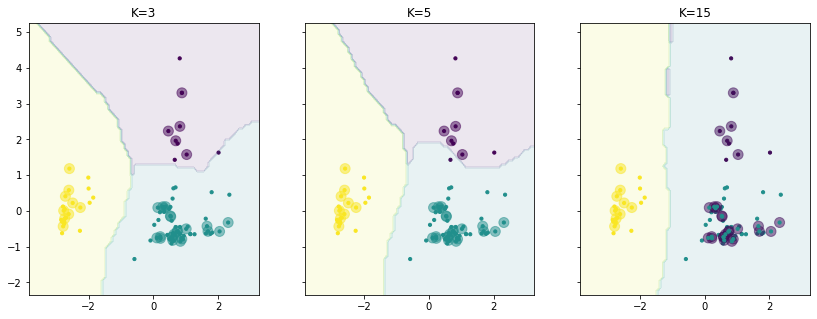

In [12]:
# pair-wise distance between test data and training data
d = cdist(X[test,:], X[train, :])
Ks = [3, 5, 15] # different number of neighbours
fig, axs = plt.subplots(1, 3, figsize=[14, 5], sharey=True) # define figure

for c, K in enumerate(Ks):
    ik = d.argsort()[:, :K] # the indices for the K closest points
    # find majority label in K closest points for test data
    Y_pred = []
    for i in range(36):
        # mode label in the set of K nearest points
        pred,_ = mode(Y[train][ik[i,:]])
        Y_pred.append(pred)
    # predict over mesh - same as above
    x1, x2, yy = mesh()
    # plot the data, colour with labels
    axs[c].scatter(X[train,0], X[train,1], s=10, c=Y[train])
    axs[c].scatter(X[test,0], X[test,1], s=100, c=Y_pred, alpha=.5)
    axs[c].scatter(X[test,0], X[test,1], s=10, c=Y[test])
    axs[c].contourf(x1,x2, yy, alpha=0.1) # mesh predictions
    axs[c].set_title('K=' + str(K))

### KNN: Validation

It makes sense to select $K$ to improve the predictive performance - Generalisation

We _cannot_ use the test data to inform this choice - **Over-fitting** risks

Model validation: separate a subset of the training data for validation, to select the best $K$

### Leave-One-Out Cross-Validation

<img src="images/kfold.png" width="300"/>

(_Rogers, Girolami, 2017_)

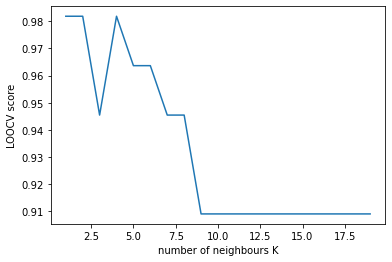

In [9]:
Ks = range(1,20) # different number of neighbours

score = []
for c, K in enumerate(Ks):    
    s = 0
    for i in train: # leave out each point in turn as a test point
        LOO_test = i
        LOO_train = np.setdiff1d(train, i) # separate from the rest
        d_ = cdist(X[LOO_test,:].reshape(1,2), X[LOO_train, :]) # distances
        ik = d_.argsort().squeeze()[:K] # K closest to that point
        pred,_ = mode(Y[LOO_train][ik]) # majority label
        s += (pred== Y[i]) # add +1 to score if correct
    score.append(s/55) # average
# plot
plt.plot(np.arange(1,20), score)
plt.ylabel('LOOCV score')
plt.xlabel('number of neighbours K')
plt.show()

## Clustering
### Unsupervised learning

### Clustering: Unsupervised Learning

What if labels $\mathbf{y}_i$ for the data are unavailable?

In this case, a form of **unsupervised learning** is appropriate: algorithms learnt from the observation data $\mathbf{x}_i$ only

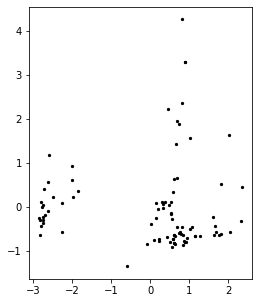

In [10]:
plt.figure(figsize=[4, 5])
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.show()

Clustering - creates a grouping of objects, such that objects within each group are similar, while objects in different groups are dissimilar. (_Rogers, Girolami, 2017_)

A definition of similarity?
$$
d(\mathbf{x}_{i}, \mathbf{x}_{i\prime}) = (\mathbf{x}_i - \mathbf{x}_{i\prime})^\top (\mathbf{x}_i - \mathbf{x}_{i\prime})
$$

### K-Means Clustering

Considers cluster centroids, to find optimal $K$ clusters in data.

Optimal clustering minimises the distances between all data and their cluster centers...

#### Algorithm:

1. start with some random guess for the center of each cluster $\{\mathbf{\mu}_1, \ldots, \mathbf{\mu}_k\}$
2. assign each point in the dataset to its closest (most similar) cluster centroid

    $\hat{y}_i = \textrm{argmin}_k\left\{d(\mathbf{\mu}_k,\mathbf{x}_i)\right\}$
    
3. update cluster centers $\{1, \ldots, K\}$ by computing the mean average of the data assigned to it

    $ \mathbf{\mu}_k = 1/N_k \sum_{i:\hat{y}_i=k} \mathbf{x}_i $
    
Repeat steps 2 - 3 until converged.

Connections with probabilistic models - Gaussian Mixture Models (GMMS)

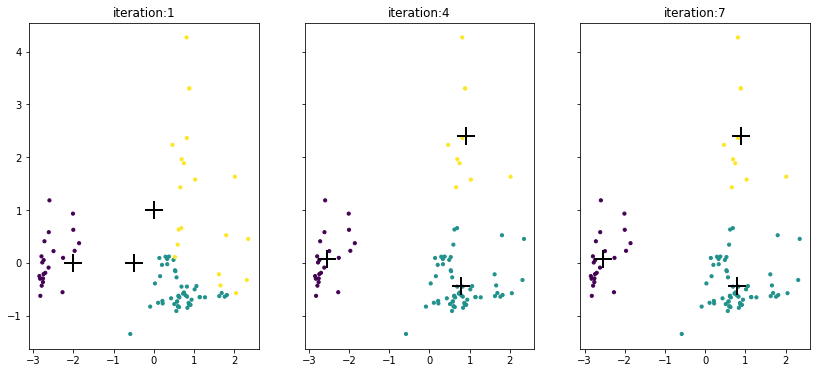

In [11]:
# init. centoroids
K = 3
# mu = np.random.uniform(-3, 3, size=[K,2])
mu = np.array([[-2, 0], [-.5, 0], [0, 1]])
c = 0 # count for ploting
fig, axs = plt.subplots(1, 3, figsize=[14, 6], sharey=True)
# iterate
for itr in range(7):
    d = cdist(X, mu) # distance to centres
    y_pred = d.argmin(1) # assign to closest center
    if itr%3 == 0: # plot every third iteration
        axs[c].scatter(X[:,0], X[:,1],c=y_pred, s=10)
        axs[c].scatter(mu[:,0], mu[:,1], s=300, 
                       marker='+', c='k', linewidth=2)
        axs[c].set_title('iteration:' + str(itr+1))
        c+=1    
    for k in range(K):
        mu[k,:] = np.mean(X[y_pred==k, :], axis=0)      
plt.show()

### Validation: Unsupervised learning

- validating $K$ becomes problematic - there is no clear solution!
- consider the application, you may have this domain knowledge
- models for automatic inference of $K$

### Summary

- Introduction to ML
    - Supervised learning
    - Unsupervised learning

- Engineering case study
    - Classification (supervised learning)
    - Clustering (unsupervised learning)

**Next time:**

What if your targets $\mathbf{y}_i$ are _continuous_, not discrete classes/groups?

**Regression...**
<img src="images/het_GP.png" width="500"/>



### Thanks for listening!

any questions: <l.a.bull@sheffield.ac.uk>
